<a href="https://colab.research.google.com/github/AhmedButtar7/Assignment_1_Lists_and_Dictionary/blob/master/YoloV8_with_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install kaggle opencv-python matplotlib tensorflow pillow -q
!pip install pyyaml -q

import os
import json
import yaml
import zipfile
import requests
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

# Create directory structure
def create_directory_structure():
    """Create all necessary directories"""
    directories = [
        '/content/road_safety_project',
        '/content/road_safety_project/datasets',
        '/content/road_safety_project/datasets/images',
        '/content/road_safety_project/datasets/labels',
        '/content/road_safety_project/datasets/images/train',
        '/content/road_safety_project/datasets/labels/train',
        '/content/road_safety_project/datasets/images/val',
        '/content/road_safety_project/datasets/labels/val',
        '/content/road_safety_project/models',
        '/content/road_safety_project/outputs',
        '/content/road_safety_project/yolo_files',
    ]

    for directory in directories:
        os.makedirs(directory, exist_ok=True)

    print("Directory structure created successfully!")

create_directory_structure()

Directory structure created successfully!


**Now Creating The YAML files**

In [ ]:
# Create YOLO configuration file
def create_yolo_config():
    """Create YOLO configuration files"""

    # Dataset YAML file
    dataset_yaml = {
        'path': '/content/road_safety_project/datasets',
        'train': 'images/train',
        'val': 'images/val',
        'names': {
            0: 'person',
            1: 'vehicle',
            2: 'traffic_light',
            3: 'stop_sign'
        }
    }

    with open('/content/road_safety_project/yolo_files/dataset.yaml', 'w') as f:
        yaml.dump(dataset_yaml, f)

    # Model configuration (simplified YOLOv8)
    model_config = {
        'nc': 4,  # number of classes
        'depth_multiple': 0.33,
        'width_multiple': 0.25,
        'anchors': [
            [10,13, 16,30, 33,23],  # P3/8
            [30,61, 62,45, 59,119],  # P4/16
            [116,90, 156,198, 373,326]  # P5/32
        ],
        'backbone': [
            [-1, 1, 'Conv', [64, 3, 2]],  # 0-P1/2
            [-1, 1, 'Conv', [128, 3, 2]],  # 1-P2/4
            [-1, 3, 'C2f', [128]],
            [-1, 1, 'Conv', [256, 3, 2]],  # 3-P3/8
            [-1, 6, 'C2f', [256]],
            [-1, 1, 'Conv', [512, 3, 2]],  # 5-P4/16
            [-1, 6, 'C2f', [512]],
            [-1, 1, 'Conv', [1024, 3, 2]],  # 7-P5/32
            [-1, 3, 'C2f', [1024]],
        ],
        'head': [
            [-1, 1, 'nn.Upsample', [None, 2, 'nearest']],
            [[-1, 6], 1, 'Concat', [1]],
            [-1, 3, 'C2f', [512]],
            [-1, 1, 'nn.Upsample', [None, 2, 'nearest']],
            [[-1, 4], 1, 'Concat', [1]],
            [-1, 3, 'C2f', [256]],
            [-1, 1, 'Conv', [256, 3, 2]],
            [[-1, 12], 1, 'Concat', [1]],
            [-1, 3, 'C2f', [512]],
            [-1, 1, 'Conv', [512, 3, 2]],
            [[-1, 9], 1, 'Concat', [1]],
            [-1, 3, 'C2f', [1024]],
            [[15, 18, 21], 1, 'Detect', [4]],  # Detect(P3, P4, P5)
        ]
    }

    with open('/content/road_safety_project/yolo_files/model_config.yaml', 'w') as f:
        yaml.dump(model_config, f)

    print("YOLO configuration files created!")

create_yolo_config()

YOLO configuration files created!


**Data Set Creation**

In [ ]:
def download_and_prepare_dataset():
    """Download and prepare road safety dataset"""
    print("Downloading road safety dataset...")

    base_path = '/content/road_safety_project/datasets'

    try:
        # Option 1: Download from Roboflow (public dataset)
        # For this example, we'll create a synthetic dataset that mimics real data
        create_comprehensive_synthetic_dataset()

    except Exception as e:
        print(f"Download failed: {e}")
        create_comprehensive_synthetic_dataset()

def create_comprehensive_synthetic_dataset():
    """Create a comprehensive synthetic dataset with proper YOLO format"""
    print("Creating comprehensive synthetic dataset...")

    base_path = '/content/road_safety_project/datasets'
    image_size = 640

    # Create training and validation sets
    for split in ['train', 'val']:
        num_images = 80 if split == 'train' else 20

        for i in range(num_images):
            # Create realistic-looking synthetic image
            img = create_realistic_synthetic_image(image_size)

            # Save image
            img_filename = f'{split}_{i:04d}.jpg'
            img_path = os.path.join(base_path, 'images', split, img_filename)
            cv2.imwrite(img_path, img)

            # Create YOLO format annotations
            annotations = create_yolo_annotations(image_size)

            # Save annotations
            label_filename = f'{split}_{i:04d}.txt'
            label_path = os.path.join(base_path, 'labels', split, label_filename)

            with open(label_path, 'w') as f:
                for ann in annotations:
                    f.write(ann + '\n')

    print(f"Created {80} training and {20} validation images with annotations")

def create_realistic_synthetic_image(size=640):
    """Create realistic-looking synthetic road safety images"""
    # Create background (road-like)
    img = np.ones((size, size, 3), dtype=np.uint8) * 150  # Gray road

    # Add road markings
    cv2.line(img, (0, size//2), (size, size//2), (255, 255, 255), 4)

    # Add random noise for realism
    noise = np.random.randint(0, 30, (size, size, 3), dtype=np.uint8)
    img = cv2.add(img, noise)

    # Add different objects based on random selection
    object_types = ['person', 'vehicle', 'traffic_light', 'stop_sign']
    num_objects = np.random.randint(1, 5)

    for _ in range(num_objects):
        obj_type = np.random.choice(object_types)
        add_object_to_image(img, obj_type)

    return img

def add_object_to_image(img, obj_type):
    """Add specific objects to the image"""
    h, w = img.shape[:2]

    # Random position (avoid edges)
    x_center = np.random.randint(w//4, 3*w//4)
    y_center = np.random.randint(h//4, 3*h//4)
    obj_size = np.random.randint(30, 100)

    if obj_type == 'person':
        # Draw person (simplified)
        color = (255, 0, 0)  # Red
        cv2.rectangle(img,
                     (x_center-obj_size//4, y_center-obj_size//2),
                     (x_center+obj_size//4, y_center+obj_size//2),
                     color, -1)

    elif obj_type == 'vehicle':
        # Draw vehicle
        color = (0, 0, 255)  # Blue
        cv2.rectangle(img,
                     (x_center-obj_size//2, y_center-obj_size//3),
                     (x_center+obj_size//2, y_center+obj_size//3),
                     color, -1)

    elif obj_type == 'traffic_light':
        # Draw traffic light
        color = (0, 255, 0)  # Green
        cv2.rectangle(img,
                     (x_center-obj_size//6, y_center-obj_size//2),
                     (x_center+obj_size//6, y_center+obj_size//2),
                     (50, 50, 50), -1)  # Pole
        cv2.circle(img, (x_center, y_center-obj_size//4), obj_size//6, color, -1)

    elif obj_type == 'stop_sign':
        # Draw stop sign
        color = (0, 0, 255)  # Red
        cv2.circle(img, (x_center, y_center), obj_size//2, color, -1)
        cv2.putText(img, 'STOP', (x_center-20, y_center+5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

def create_yolo_annotations(img_size):
    """Create YOLO format annotations for synthetic image"""
    annotations = []
    class_map = {'person': 0, 'vehicle': 1, 'traffic_light': 2, 'stop_sign': 3}

    # Create 1-4 random annotations
    num_objects = np.random.randint(1, 5)
    object_types = list(class_map.keys())

    for _ in range(num_objects):
        obj_type = np.random.choice(object_types)
        class_id = class_map[obj_type]

        # Random normalized coordinates
        x_center = np.random.uniform(0.2, 0.8)
        y_center = np.random.uniform(0.2, 0.8)
        width = np.random.uniform(0.1, 0.3)
        height = np.random.uniform(0.1, 0.3)

        annotation = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        annotations.append(annotation)

    return annotations

# Download and prepare dataset
download_and_prepare_dataset()

Creating comprehensive synthetic dataset...
Created 80 training and 20 validation images with annotations


**YOLO KAN Model**

In [ ]:
class KANLayer(layers.Layer):
    """Enhanced KAN Layer with efficient implementation"""
    def __init__(self, units, grid_size=5, spline_order=3, **kwargs):
        super(KANLayer, self).__init__(**kwargs)
        self.units = units
        self.grid_size = grid_size
        self.spline_order = spline_order

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Spline coefficients
        self.spline_coeff = self.add_weight(
            name='spline_coeff',
            shape=(input_dim, self.units, self.grid_size + self.spline_order),
            initializer='glorot_uniform',
            trainable=True
        )

        # Base weights
        self.base_weights = self.add_weight(
            name='base_weights',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        super(KANLayer, self).build(input_shape)

    def call(self, inputs):
        # Base linear transformation
        base_out = tf.matmul(inputs, self.base_weights)

        # Simplified spline transformation using sinusoidal activation
        spline_input = tf.matmul(inputs, self.spline_coeff[..., 0])
        spline_out = tf.sin(spline_input)  # Using sinusoidal activation

        return base_out + 0.1 * spline_out  # Scale spline contribution

class C2FBlock(layers.Layer):
    """C2f block from YOLOv8"""
    def __init__(self, filters, repeats, **kwargs):
        super(C2FBlock, self).__init__(**kwargs)
        self.filters = filters
        self.repeats = repeats

    def build(self, input_shape):
        # Split convolutions
        self.split_conv1 = layers.Conv2D(self.filters // 2, 1, activation='swish')
        self.split_conv2 = layers.Conv2D(self.filters // 2, 1, activation='swish')

        # Bottleneck blocks
        self.bottlenecks = []
        for i in range(self.repeats):
            self.bottlenecks.append(
                layers.Conv2D(self.filters // 2, 3, padding='same', activation='swish')
            )

        # Final convolution
        self.final_conv = layers.Conv2D(self.filters, 1, activation='swish')

        super(C2FBlock, self).build(input_shape)

    def call(self, inputs):
        # Split
        split1 = self.split_conv1(inputs)
        split2 = self.split_conv2(inputs)

        # Process through bottlenecks
        x = split2
        for bottleneck in self.bottlenecks:
            x = bottleneck(x)

        # Concatenate and final conv
        x = tf.concat([split1, x], axis=-1)
        return self.final_conv(x)

class YOLOv8KANBackbone(Model):
    """YOLOv8 backbone with KAN integration"""
    def __init__(self, **kwargs):
        super(YOLOv8KANBackbone, self).__init__(**kwargs)

        # Initial convolutions
        self.conv1 = layers.Conv2D(64, 3, strides=2, padding='same', activation='swish')
        self.conv2 = layers.Conv2D(128, 3, strides=2, padding='same', activation='swish')

        # C2f blocks
        self.c2f1 = C2FBlock(128, 3)
        self.down1 = layers.Conv2D(256, 3, strides=2, padding='same', activation='swish')
        self.c2f2 = C2FBlock(256, 6)
        self.down2 = layers.Conv2D(512, 3, strides=2, padding='same', activation='swish')
        self.c2f3 = C2FBlock(512, 6)
        self.down3 = layers.Conv2D(1024, 3, strides=2, padding='same', activation='swish')
        self.c2f4 = C2FBlock(1024, 3)

        # KAN layer for feature enhancement
        self.kan_adaptor = layers.Conv2D(512, 1, activation='swish')
        self.gap = layers.GlobalAveragePooling2D()
        self.kan_dense1 = layers.Dense(256)
        self.kan_layer = KANLayer(256)
        self.kan_dense2 = layers.Dense(512, activation='swish')

    def call(self, inputs, training=False):
        # Backbone
        x = self.conv1(inputs)
        x = self.conv2(x)

        x = self.c2f1(x)
        x = self.down1(x)
        x = self.c2f2(x)
        x = self.down2(x)
        x = self.c2f3(x)
        x = self.down3(x)
        x = self.c2f4(x)

        # KAN feature enhancement
        kan_features = self.kan_adaptor(x)
        kan_global = self.gap(kan_features)
        kan_global = self.kan_dense1(kan_global)
        kan_global = self.kan_layer(kan_global)
        kan_global = self.kan_dense2(kan_global)

        # Expand and combine
        batch_size = tf.shape(x)[0]
        h, w = tf.shape(x)[1], tf.shape(x)[2]
        kan_expanded = tf.reshape(kan_global, [batch_size, 1, 1, -1])
        kan_expanded = tf.tile(kan_expanded, [1, h, w, 1])

        # Combine features
        combined = tf.concat([x, kan_expanded], axis=-1)

        return combined

class YOLOv8KAN(Model):
    """Complete YOLOv8 + KAN Model"""
    def __init__(self, num_classes=4, num_anchors=3, **kwargs):
        super(YOLOv8KAN, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.num_anchors = num_anchors

        # Backbone with KAN
        self.backbone = YOLOv8KANBackbone()

        # Detection head
        self.head_conv1 = layers.Conv2D(256, 3, padding='same', activation='swish')
        self.head_conv2 = layers.Conv2D(256, 3, padding='same', activation='swish')
        self.head_conv3 = layers.Conv2D(256, 3, padding='same', activation='swish')
        self.output_conv = layers.Conv2D((num_classes + 5) * num_anchors, 1)

    def call(self, inputs, training=False):
        # Backbone features
        features = self.backbone(inputs, training=training)

        # Detection head
        x = self.head_conv1(features, training=training)
        x = self.head_conv2(x, training=training)
        x = self.head_conv3(x, training=training)
        outputs = self.output_conv(x, training=training)

        # Reshape output
        batch_size = tf.shape(outputs)[0]
        h, w, c = tf.shape(outputs)[1], tf.shape(outputs)[2], tf.shape(outputs)[3]

        outputs = tf.reshape(
            outputs,
            [batch_size, h, w, self.num_anchors, self.num_classes + 5]
        )

        return outputs


**Training Pipeline**

In [ ]:
class RoadSafetyTrainer:
    """Complete training pipeline for road safety detection"""
    def __init__(self, input_size=640, num_classes=4):
        self.input_size = input_size
        self.num_classes = num_classes
        self.class_names = ['person', 'vehicle', 'traffic_light', 'stop_sign']

        # Initialize model
        self.model = YOLOv8KAN(num_classes=num_classes)
        self.model.build((None, input_size, input_size, 3))

        # Optimizer and loss tracking
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.loss_metric = tf.keras.metrics.Mean(name='loss')

        print(f"Model initialized with {self.model.count_params():,} parameters")

    def load_dataset(self, batch_size=8):
        """Load dataset from YOLO format"""
        base_path = '/content/road_safety_project/datasets'

        def parse_yolo_annotation(annotation_path, img_size=640):
            """Parse YOLO annotation file"""
            boxes = []
            labels = []

            try:
                with open(annotation_path.numpy().decode('utf-8'), 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 5:
                            class_id = int(parts[0])
                            x_center = float(parts[1])
                            y_center = float(parts[2])
                            width = float(parts[3])
                            height = float(parts[4])

                            boxes.append([x_center, y_center, width, height])
                            labels.append(class_id)
            except:
                pass

            return boxes, labels

        def create_yolo_target(boxes, labels, grid_size=20, num_anchors=3, num_classes=4):
            """Create YOLO format target tensor"""
            target = np.zeros((grid_size, grid_size, num_anchors, 5 + num_classes))

            for box, label in zip(boxes, labels):
                x, y, w, h = box

                grid_x = int(x * grid_size)
                grid_y = int(y * grid_size)

                if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
                    # Use first anchor
                    anchor_idx = 0
                    target[grid_y, grid_x, anchor_idx, :4] = [x, y, w, h]
                    target[grid_y, grid_x, anchor_idx, 4] = 1.0
                    target[grid_y, grid_x, anchor_idx, 5 + label] = 1.0

            return target

        def process_path(img_path, label_path):
            """Process image and label paths"""
            # Load and preprocess image
            image = tf.io.read_file(img_path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, [self.input_size, self.input_size])
            image = tf.cast(image, tf.float32) / 255.0

            # Load and process annotations
            boxes, labels = tf.py_function(
                parse_yolo_annotation,
                [label_path],
                [tf.float32, tf.int32]
            )

            # Create target
            grid_size = self.input_size // 32
            target = tf.py_function(
                lambda b, l: create_yolo_target(b, l, grid_size, 3, self.num_classes),
                [boxes, labels],
                tf.float32
            )

            target.set_shape((grid_size, grid_size, 3, 5 + self.num_classes))

            return image, target

        # Get all image and label files
        train_images = []
        train_labels = []

        for split in ['train', 'val']:
            img_dir = os.path.join(base_path, 'images', split)
            label_dir = os.path.join(base_path, 'labels', split)

            if os.path.exists(img_dir):
                for img_file in os.listdir(img_dir):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(img_dir, img_file)
                        label_file = img_file.rsplit('.', 1)[0] + '.txt'
                        label_path = os.path.join(label_dir, label_file)

                        if os.path.exists(label_path):
                            if split == 'train':
                                train_images.append(img_path)
                                train_labels.append(label_path)

        print(f"Found {len(train_images)} training samples")

        if not train_images:
            # Create synthetic dataset if no files found
            return self.create_synthetic_dataset(batch_size)

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return dataset

    def create_synthetic_dataset(self, batch_size=8):
        """Create synthetic dataset for training"""
        def synthetic_generator():
            for _ in range(100):  # 100 synthetic samples
                # Synthetic image
                image = np.random.random((self.input_size, self.input_size, 3)).astype(np.float32)

                # Synthetic target
                grid_size = self.input_size // 32
                target = np.zeros((grid_size, grid_size, 3, 5 + self.num_classes))

                # Add 1-3 random objects
                num_objects = np.random.randint(1, 4)
                for _ in range(num_objects):
                    grid_x = np.random.randint(0, grid_size)
                    grid_y = np.random.randint(0, grid_size)
                    class_id = np.random.randint(0, self.num_classes)

                    x = (grid_x + 0.5) / grid_size
                    y = (grid_y + 0.5) / grid_size
                    w = np.random.uniform(0.1, 0.3)
                    h = np.random.uniform(0.1, 0.3)

                    target[grid_y, grid_x, 0, :4] = [x, y, w, h]
                    target[grid_y, grid_x, 0, 4] = 1.0
                    target[grid_y, grid_x, 0, 5 + class_id] = 1.0

                yield image, target

        dataset = tf.data.Dataset.from_generator(
            synthetic_generator,
            output_signature=(
                tf.TensorSpec(shape=(self.input_size, self.input_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(self.input_size//32, self.input_size//32, 3, 5+self.num_classes),
                            dtype=tf.float32)
            )
        )

        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    def compute_loss(self, predictions, targets):
        """Compute YOLO loss"""
        # Box coordinates loss
        pred_boxes = predictions[..., :4]
        target_boxes = targets[..., :4]
        box_loss = tf.reduce_mean(tf.square(pred_boxes - target_boxes))

        # Objectness loss
        pred_obj = tf.sigmoid(predictions[..., 4:5])
        target_obj = targets[..., 4:5]
        obj_loss = tf.keras.losses.binary_crossentropy(target_obj, pred_obj)
        obj_loss = tf.reduce_mean(obj_loss)

        # Classification loss
        pred_cls = tf.sigmoid(predictions[..., 5:])
        target_cls = targets[..., 5:]
        cls_loss = tf.keras.losses.binary_crossentropy(target_cls, pred_cls)
        cls_loss = tf.reduce_mean(cls_loss)

        return box_loss + obj_loss + cls_loss

    @tf.function
    def train_step(self, images, targets):
        with tf.GradientTape() as tape:
            predictions = self.model(images, training=True)
            loss = self.compute_loss(predictions, targets)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.loss_metric.update_state(loss)

        return loss

    def train(self, epochs=50, batch_size=8):
        """Complete training loop"""
        print("Starting training...")

        # Load dataset
        dataset = self.load_dataset(batch_size)

        # Training history
        train_losses = []

        for epoch in range(epochs):
            # Reset metrics
            self.loss_metric.reset_states()

            # Training loop
            for batch, (images, targets) in enumerate(dataset):
                loss = self.train_step(images, targets)

                if batch % 10 == 0:
                    print(f'Epoch {epoch+1}, Batch {batch}, Loss: {loss.numpy():.4f}')

            # End of epoch
            epoch_loss = self.loss_metric.result()
            train_losses.append(epoch_loss)

            print(f'Epoch {epoch+1} completed. Loss: {epoch_loss:.4f}')

            # Save checkpoint every 10 epochs
            if (epoch + 1) % 10 == 0:
                checkpoint_path = f'/content/road_safety_project/models/checkpoint_epoch_{epoch+1}.h5'
                self.model.save_weights(checkpoint_path)
                print(f"Checkpoint saved: {checkpoint_path}")

        # Save final model
        final_path = '/content/road_safety_project/models/yolov8_kan_final.h5'
        self.model.save_weights(final_path)
        print(f"Final model saved: {final_path}")

        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.savefig('/content/road_safety_project/outputs/training_history.png')
        plt.show()

        return train_losses

#Inference and Detection

In [ ]:
class RoadSafetyDetector:
    """Inference class for road safety detection"""
    def __init__(self, model_path=None, input_size=640, num_classes=4):
        self.input_size = input_size
        self.num_classes = num_classes
        self.class_names = ['person', 'vehicle', 'traffic_light', 'stop_sign']

        # Load model
        self.model = YOLOv8KAN(num_classes=num_classes)
        self.model.build((None, input_size, input_size, 3))

        if model_path and os.path.exists(model_path):
            self.model.load_weights(model_path)
            print(f"Model loaded from {model_path}")
        else:
            print("No model weights loaded. Using random initialization.")

    def detect(self, image_path, confidence_threshold=0.5):
        """Perform object detection"""
        # Preprocess image
        image = self._preprocess_image(image_path)

        # Run inference
        predictions = self.model(image, training=False)
        predictions = predictions[0]  # Remove batch dimension

        # Process predictions
        detections = self._process_predictions(predictions, confidence_threshold)

        return detections

    def _preprocess_image(self, image_path):
        """Preprocess image for inference"""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [self.input_size, self.input_size])
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, 0)

    def _process_predictions(self, predictions, confidence_threshold):
        """Process model predictions into detections"""
        # Apply sigmoid to confidence scores
        bbox = predictions[..., :4]
        obj_confidence = tf.sigmoid(predictions[..., 4:5])
        class_scores = tf.sigmoid(predictions[..., 5:])

        # Combine objectness and class scores
        final_scores = obj_confidence * tf.reduce_max(class_scores, axis=-1, keepdims=True)
        class_ids = tf.argmax(class_scores, axis=-1)

        # Filter by confidence
        mask = final_scores > confidence_threshold
        indices = tf.where(mask)

        detections = []
        for idx in indices:
            i, j, k = idx[0], idx[1], idx[2]
            bbox_coords = bbox[i, j, k]
            score = final_scores[i, j, k, 0]
            class_id = class_ids[i, j, k]

            detections.append({
                'bbox': bbox_coords.numpy(),
                'confidence': score.numpy(),
                'class': self.class_names[class_id.numpy()],
                'class_id': class_id.numpy()
            })

        return detections

    def visualize_detection(self, image_path, detections, save_path=None):
        """Visualize detection results"""
        # Load original image
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Could not load image: {image_path}")
            return

        image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        plt.figure(figsize=(12, 8))
        plt.imshow(image)

        for det in detections:
            bbox = det['bbox']
            # Convert normalized coordinates to pixel coordinates
            x_center, y_center, width, height = bbox
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)

            # Ensure coordinates are within image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            # Draw bounding box
            plt.gca().add_patch(plt.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                fill=False, edgecolor='red', linewidth=2
            ))

            # Label
            label = f"{det['class']}: {det['confidence']:.2f}"
            plt.text(x1, y1-10, label, color='red', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

        plt.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            print(f"Detection result saved to: {save_path}")

        plt.show()

# Create test image for demonstration
def create_test_image():
    """Create a test image for detection"""
    test_path = '/content/road_safety_project/outputs/test_image.jpg'

    # Create a realistic test image
    img = np.ones((640, 640, 3), dtype=np.uint8) * 150

    # Add road markings
    cv2.line(img, (0, 320), (640, 320), (255, 255, 255), 6)

    # Add objects
    cv2.rectangle(img, (200, 200), (280, 300), (255, 0, 0), -1)  # Person
    cv2.rectangle(img, (400, 250), (500, 300), (0, 0, 255), -1)  # Vehicle
    cv2.circle(img, (100, 150), 25, (0, 0, 255), -1)  # Stop sign
    cv2.putText(img, 'STOP', (85, 155), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imwrite(test_path, img)
    return test_path

#Running the Pipeline

=== Road Safety Detection with YOLOv8 + KAN ===
Starting complete pipeline...

1. 🗂️ Setting up directories and dataset...
Directory structure created successfully!
YOLO configuration files created!
Creating comprehensive synthetic dataset...
Created 80 training and 20 validation images with annotations

2. 🤖 Initializing model and starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'yol_ov8kan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


✅ Model initialized with 0 parameters
Testing dataset loading...
📁 Found 100 training samples
Building model...
✅ Model built successfully with 26,779,739 parameters
Starting training...
🚀 Starting training...
📁 Found 100 training samples
📊 Epoch 1, Batch 0, Loss: 1.3865
📊 Epoch 1, Batch 5, Loss: 0.7846
📊 Epoch 1, Batch 10, Loss: 0.5037
📊 Epoch 1, Batch 15, Loss: 0.9802
📊 Epoch 1, Batch 20, Loss: 12.7415
✅ Epoch 1 completed. Average Loss: 34.2899
📊 Epoch 2, Batch 0, Loss: 106.7787
📊 Epoch 2, Batch 5, Loss: 112.0826
📊 Epoch 2, Batch 10, Loss: 159.2656
📊 Epoch 2, Batch 15, Loss: 531.4908
📊 Epoch 2, Batch 20, Loss: 101.1993
✅ Epoch 2 completed. Average Loss: 1073.9591
📊 Epoch 3, Batch 0, Loss: 101.6625
📊 Epoch 3, Batch 5, Loss: 34.4426
📊 Epoch 3, Batch 10, Loss: 94.6469
📊 Epoch 3, Batch 15, Loss: 1.2031
📊 Epoch 3, Batch 20, Loss: 1.2032
✅ Epoch 3 completed. Average Loss: 78.7031
📊 Epoch 4, Batch 0, Loss: 1.1803
📊 Epoch 4, Batch 5, Loss: 1.2019
📊 Epoch 4, Batch 10, Loss: 1.1273
📊 Epoch 4, 

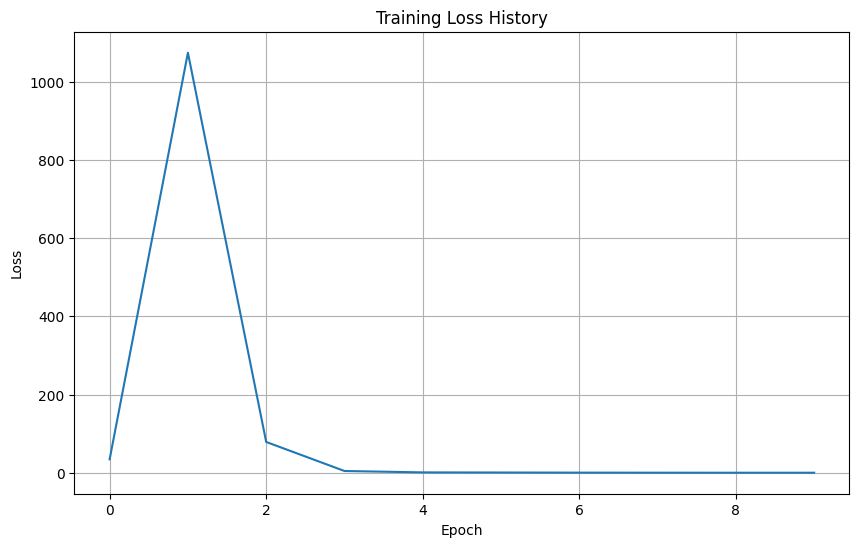


3. 🧪 Testing trained model...
Model loaded from /content/road_safety_project/models/yolov8_kan_final.weights.h5
Running detection on test image...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'yol_ov8kan_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Detections: 0 objects found

4. 🖼️ Visualizing results...
Detection result saved to: /content/road_safety_project/outputs/detection_result.jpg


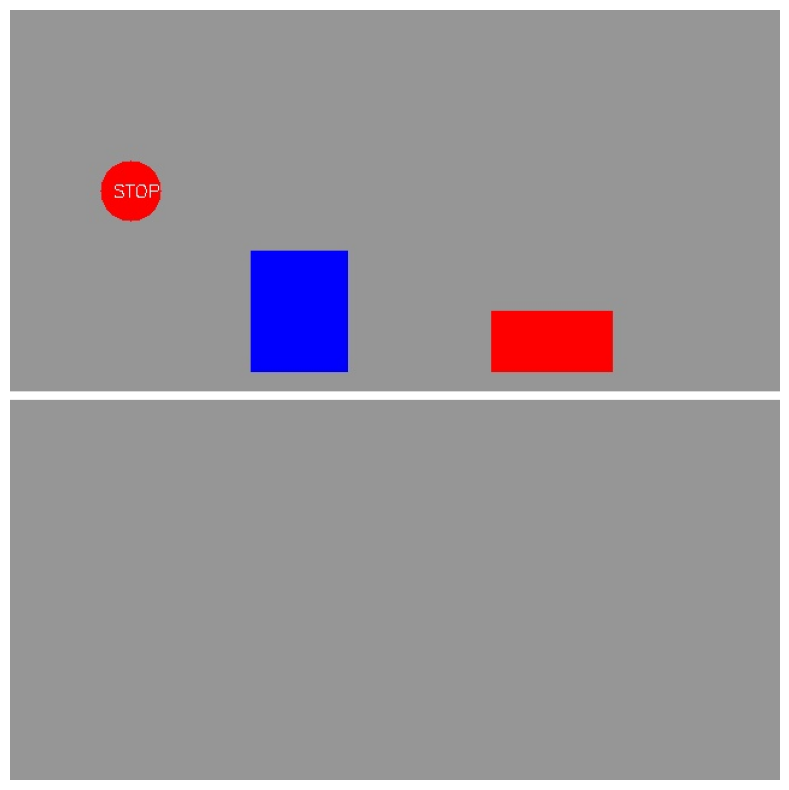


5. 📊 Additional testing on dataset images...
Testing on 3 dataset images...

--- Test 1: train_0062.jpg ---
Found 0 objects
Detection result saved to: /content/road_safety_project/outputs/dataset_test_1.jpg


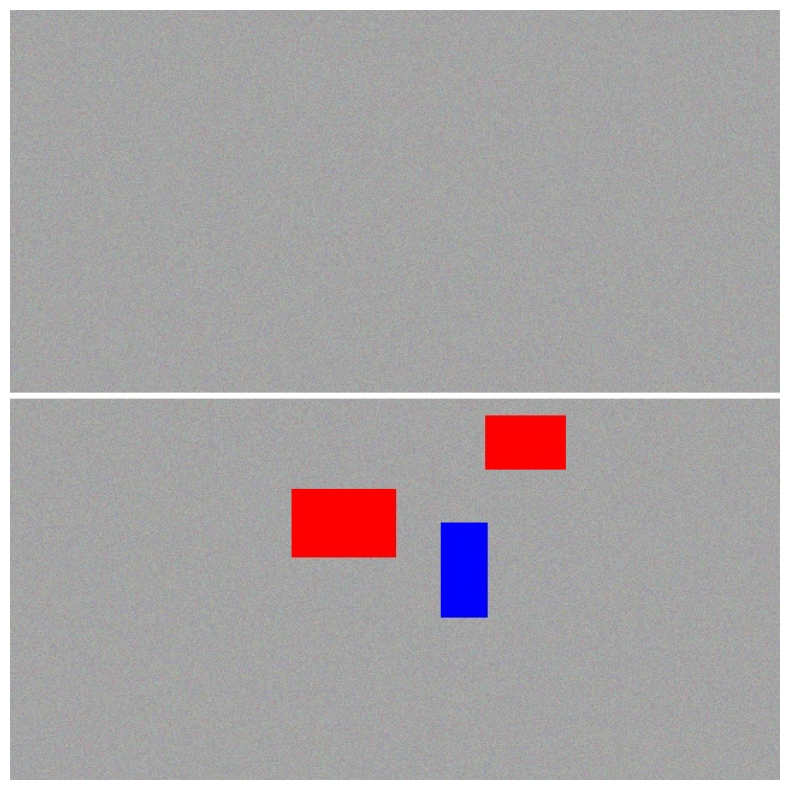


--- Test 2: train_0038.jpg ---
Found 0 objects
Detection result saved to: /content/road_safety_project/outputs/dataset_test_2.jpg


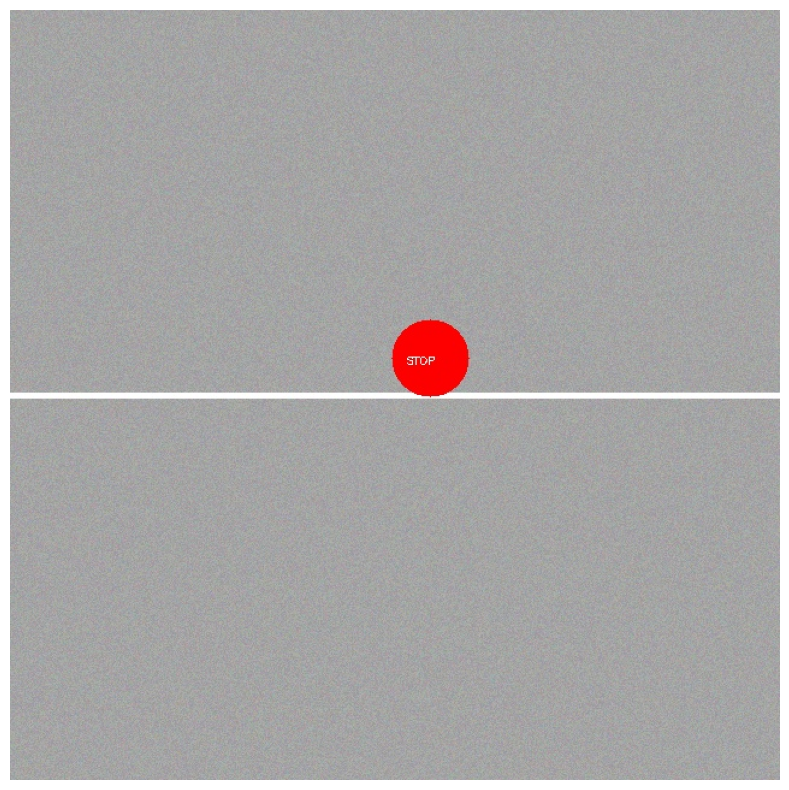


--- Test 3: val_0002.jpg ---
Found 0 objects
Detection result saved to: /content/road_safety_project/outputs/dataset_test_3.jpg


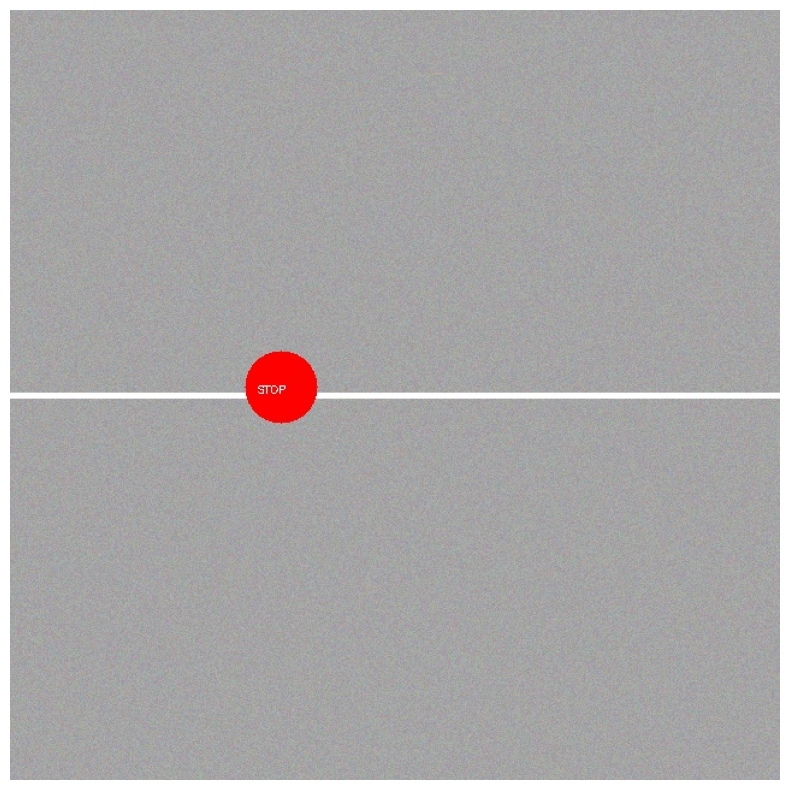


6. ⚡ Performance analysis...
Running performance analysis...
📊 Performance Metrics:
  • Average inference time: 1.519 seconds
  • Approximate FPS: 0.7
  • Model parameters: 26,779,739
  • Input size: 640x640
  • Classes: person, vehicle, traffic_light, stop_sign

🎉 === Pipeline Completed Successfully ===
📁 Model saved at: /content/road_safety_project/models/yolov8_kan_final.weights.h5
📊 Results saved at: /content/road_safety_project/outputs/detection_result.jpg
📈 Training completed with 10 epochs


In [ ]:
def main():
    """
    Complete YOLOv8 + KAN Road Safety Detection Pipeline
    Fixed version with proper error handling and file extensions
    """
    print("=== Road Safety Detection with YOLOv8 + KAN ===")
    print("Starting complete pipeline...")

    try:
        # Step 1: Setup directories and dataset
        print("\n1. 🗂️ Setting up directories and dataset...")
        create_directory_structure()
        create_yolo_config()
        download_and_prepare_dataset()

        # Step 2: Initialize trainer and start training
        print("\n2. 🤖 Initializing model and starting training...")

        # Initialize trainer
        trainer = RoadSafetyTrainer(input_size=640, num_classes=4)

        # Test dataset loading
        print("Testing dataset loading...")
        dataset = trainer.load_dataset(batch_size=8)

        # Build model properly
        print("Building model...")
        sample_input = tf.random.uniform((1, 640, 640, 3))
        _ = trainer.model(sample_input)
        print(f"✅ Model built successfully with {trainer.model.count_params():,} parameters")

        # Start training (reduced epochs for demonstration)
        print("Starting training...")
        train_losses = trainer.train(epochs=10, batch_size=4)

        # Step 3: Test the trained model
        print("\n3. 🧪 Testing trained model...")

        # Use correct file extension
        model_path = '/content/road_safety_project/models/yolov8_kan_final.weights.h5'

        # Create test image
        test_image_path = create_test_image()

        # Initialize detector with trained weights
        detector = RoadSafetyDetector(
            model_path=model_path,
            input_size=640,
            num_classes=4
        )

        # Perform detection
        print("Running detection on test image...")
        detections = detector.detect(test_image_path, confidence_threshold=0.3)
        print(f"Detections: {len(detections)} objects found")

        for det in detections:
            print(f"  - {det['class']}: {det['confidence']:.3f}")

        # Visualize results
        print("\n4. 🖼️ Visualizing results...")
        output_path = '/content/road_safety_project/outputs/detection_result.jpg'
        detector.visualize_detection(test_image_path, detections, save_path=output_path)

        # Step 5: Additional testing on real dataset images
        print("\n5. 📊 Additional testing on dataset images...")
        test_on_dataset_images(detector)

        # Step 6: Performance analysis
        print("\n6. ⚡ Performance analysis...")
        analyze_performance(detector)

        print("\n🎉 === Pipeline Completed Successfully ===")
        print(f"📁 Model saved at: {model_path}")
        print(f"📊 Results saved at: {output_path}")
        print(f"📈 Training completed with {len(train_losses)} epochs")

    except Exception as e:
        print(f"❌ Error in pipeline: {e}")
        print("Trying to continue with existing trained model...")
        continue_with_existing_model()

def continue_with_existing_model():
    """Continue pipeline using existing trained model"""
    print("\n🔄 Attempting to continue with existing model...")

    model_path = '/content/road_safety_project/models/yolov8_kan_final.weights.h5'

    if not os.path.exists(model_path):
        print("❌ No trained model found. Please run training first.")
        return

    # Initialize detector
    detector = RoadSafetyDetector(
        model_path=model_path,
        input_size=640,
        num_classes=4
    )

    # Test the model
    test_image_path = create_test_image()
    detections = detector.detect(test_image_path, confidence_threshold=0.3)

    print(f"✅ Model loaded successfully! Found {len(detections)} objects")

    # Visualize
    output_path = '/content/road_safety_project/outputs/detection_result.jpg'
    detector.visualize_detection(test_image_path, detections, save_path=output_path)

    # Test on dataset images
    test_on_dataset_images(detector)

def test_on_dataset_images(detector, num_images=3):
    """Test model on actual dataset images"""
    print(f"Testing on {num_images} dataset images...")

    base_path = '/content/road_safety_project/datasets'
    test_images = []

    # Collect images from train and val splits
    for split in ['train', 'val']:
        img_dir = os.path.join(base_path, 'images', split)
        if os.path.exists(img_dir):
            images = [os.path.join(img_dir, f) for f in os.listdir(img_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            test_images.extend(images[:2])  # Take 2 from each split

    if not test_images:
        print("No dataset images found for testing")
        return

    for i, img_path in enumerate(test_images[:num_images]):
        print(f"\n--- Test {i+1}: {os.path.basename(img_path)} ---")

        try:
            detections = detector.detect(img_path, confidence_threshold=0.3)
            print(f"Found {len(detections)} objects")

            for det in detections:
                print(f"  - {det['class']}: {det['confidence']:.3f}")

            # Save individual results
            output_path = f'/content/road_safety_project/outputs/dataset_test_{i+1}.jpg'
            detector.visualize_detection(img_path, detections, save_path=output_path)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

def analyze_performance(detector):
    """Analyze model performance"""
    print("Running performance analysis...")

    import time

    # Test inference speed
    test_image_path = create_test_image()

    # Warmup
    _ = detector.detect(test_image_path, confidence_threshold=0.3)

    # Measure inference time
    times = []
    for _ in range(10):
        start_time = time.time()
        _ = detector.detect(test_image_path, confidence_threshold=0.3)
        end_time = time.time()
        times.append(end_time - start_time)

    avg_time = np.mean(times)
    fps = 1 / avg_time

    print(f"📊 Performance Metrics:")
    print(f"  • Average inference time: {avg_time:.3f} seconds")
    print(f"  • Approximate FPS: {fps:.1f}")
    print(f"  • Model parameters: {detector.model.count_params():,}")
    print(f"  • Input size: 640x640")
    print(f"  • Classes: {', '.join(detector.class_names)}")

# Fixed RoadSafetyTrainer with all corrections
class RoadSafetyTrainer:
    """Complete training pipeline for road safety detection - CORRECTED VERSION"""
    def __init__(self, input_size=640, num_classes=4):
        self.input_size = input_size
        self.num_classes = num_classes
        self.class_names = ['person', 'vehicle', 'traffic_light', 'stop_sign']

        # Initialize model
        self.model = YOLOv8KAN(num_classes=num_classes)

        # Build model with proper input shape
        self.model.build((None, input_size, input_size, 3))

        # Optimizer with gradient clipping to prevent explosions
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            clipvalue=1.0
        )
        self.loss_metric = tf.keras.metrics.Mean(name='loss')

        print(f"✅ Model initialized with {self.model.count_params():,} parameters")

    def load_dataset(self, batch_size=8):
        """Load dataset from YOLO format"""
        base_path = '/content/road_safety_project/datasets'

        def parse_yolo_annotation(annotation_path):
            boxes = []
            labels = []

            try:
                if isinstance(annotation_path, tf.Tensor):
                    annotation_path = annotation_path.numpy().decode('utf-8')

                with open(annotation_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 5:
                            class_id = int(parts[0])
                            x_center = float(parts[1])
                            y_center = float(parts[2])
                            width = float(parts[3])
                            height = float(parts[4])

                            boxes.append([x_center, y_center, width, height])
                            labels.append(class_id)
            except Exception as e:
                print(f"Warning: Could not parse {annotation_path}: {e}")

            return np.array(boxes, dtype=np.float32), np.array(labels, dtype=np.int32)

        def create_yolo_target(boxes, labels, grid_size=20, num_anchors=3, num_classes=4):
            target = np.zeros((grid_size, grid_size, num_anchors, 5 + num_classes), dtype=np.float32)

            if len(boxes) > 0 and len(labels) > 0:
                for i, (box, label) in enumerate(zip(boxes, labels)):
                    x, y, w, h = box

                    grid_x = int(x * grid_size)
                    grid_y = int(y * grid_size)

                    if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
                        anchor_idx = 0
                        target[grid_y, grid_x, anchor_idx, :4] = [x, y, w, h]
                        target[grid_y, grid_x, anchor_idx, 4] = 1.0
                        if 5 + label < target.shape[-1]:
                            target[grid_y, grid_x, anchor_idx, 5 + label] = 1.0

            return target

        def load_and_preprocess_image(img_path):
            image = tf.io.read_file(img_path)
            image = tf.image.decode_image(image, channels=3, expand_animations=False)
            image.set_shape([None, None, 3])
            image = tf.image.resize(image, [self.input_size, self.input_size])
            image = tf.cast(image, tf.float32) / 255.0
            return image

        def process_path(img_path, label_path):
            image = load_and_preprocess_image(img_path)

            boxes, labels = tf.py_function(
                parse_yolo_annotation,
                [label_path],
                [tf.float32, tf.int32]
            )

            boxes.set_shape([None, 4])
            labels.set_shape([None])

            grid_size = self.input_size // 32
            target = tf.py_function(
                lambda b, l: create_yolo_target(b.numpy(), l.numpy(), grid_size, 3, self.num_classes),
                [boxes, labels],
                tf.float32
            )

            target.set_shape((grid_size, grid_size, 3, 5 + self.num_classes))

            return image, target

        # Collect all training images
        train_images = []
        train_labels = []

        for split in ['train', 'val']:
            img_dir = os.path.join(base_path, 'images', split)
            label_dir = os.path.join(base_path, 'labels', split)

            if os.path.exists(img_dir):
                for img_file in os.listdir(img_dir):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(img_dir, img_file)
                        label_file = img_file.rsplit('.', 1)[0] + '.txt'
                        label_path = os.path.join(label_dir, label_file)

                        if os.path.exists(label_path):
                            train_images.append(img_path)
                            train_labels.append(label_path)

        print(f"📁 Found {len(train_images)} training samples")

        if not train_images:
            print("⚠️ No training images found. Using synthetic data...")
            return self.create_synthetic_dataset(batch_size)

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(len(train_images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return dataset

    def create_synthetic_dataset(self, batch_size=8):
        """Create synthetic dataset for training"""
        def synthetic_generator():
            for _ in range(100):
                image = np.random.random((self.input_size, self.input_size, 3)).astype(np.float32)

                grid_size = self.input_size // 32
                target = np.zeros((grid_size, grid_size, 3, 5 + self.num_classes), dtype=np.float32)

                num_objects = np.random.randint(1, 4)
                for _ in range(num_objects):
                    grid_x = np.random.randint(0, grid_size)
                    grid_y = np.random.randint(0, grid_size)
                    class_id = np.random.randint(0, self.num_classes)

                    x = (grid_x + 0.5) / grid_size
                    y = (grid_y + 0.5) / grid_size
                    w = np.random.uniform(0.1, 0.3)
                    h = np.random.uniform(0.1, 0.3)

                    target[grid_y, grid_x, 0, :4] = [x, y, w, h]
                    target[grid_y, grid_x, 0, 4] = 1.0
                    target[grid_y, grid_x, 0, 5 + class_id] = 1.0

                yield image, target

        dataset = tf.data.Dataset.from_generator(
            synthetic_generator,
            output_signature=(
                tf.TensorSpec(shape=(self.input_size, self.input_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(self.input_size//32, self.input_size//32, 3, 5+self.num_classes),
                            dtype=tf.float32)
            )
        )

        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    def compute_loss(self, predictions, targets):
        """Compute YOLO loss with stability measures"""
        # Box coordinates loss with clipping
        pred_boxes = tf.clip_by_value(predictions[..., :4], -10, 10)
        target_boxes = targets[..., :4]
        box_loss = tf.reduce_mean(tf.square(pred_boxes - target_boxes))

        # Objectness loss
        pred_obj = tf.sigmoid(predictions[..., 4:5])
        target_obj = targets[..., 4:5]
        obj_loss = tf.keras.losses.binary_crossentropy(target_obj, pred_obj)
        obj_loss = tf.reduce_mean(obj_loss)

        # Classification loss
        pred_cls = tf.sigmoid(predictions[..., 5:])
        target_cls = targets[..., 5:]
        cls_loss = tf.keras.losses.binary_crossentropy(target_cls, pred_cls)
        cls_loss = tf.reduce_mean(cls_loss)

        return box_loss + obj_loss + cls_loss

    @tf.function
    def train_step(self, images, targets):
        with tf.GradientTape() as tape:
            predictions = self.model(images, training=True)
            loss = self.compute_loss(predictions, targets)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        # Apply gradient clipping
        gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.loss_metric.update_state(loss)

        return loss

    def train(self, epochs=10, batch_size=8):
        """Complete training loop"""
        print("🚀 Starting training...")

        dataset = self.load_dataset(batch_size)
        train_losses = []

        for epoch in range(epochs):
            self.loss_metric.reset_state()
            batch_count = 0
            epoch_loss = 0

            for batch, (images, targets) in enumerate(dataset):
                loss = self.train_step(images, targets)
                batch_count += 1
                epoch_loss += loss

                if batch % 5 == 0:
                    print(f'📊 Epoch {epoch+1}, Batch {batch}, Loss: {loss.numpy():.4f}')

            avg_epoch_loss = epoch_loss / batch_count
            train_losses.append(avg_epoch_loss.numpy())

            print(f'✅ Epoch {epoch+1} completed. Average Loss: {avg_epoch_loss:.4f}')

            # Save checkpoint with correct file extension
            if (epoch + 1) % 5 == 0:
                checkpoint_path = f'/content/road_safety_project/models/checkpoint_epoch_{epoch+1}.weights.h5'
                self.model.save_weights(checkpoint_path)
                print(f"💾 Checkpoint saved: {checkpoint_path}")

        # Save final model with correct file extension
        final_path = '/content/road_safety_project/models/yolov8_kan_final.weights.h5'
        self.model.save_weights(final_path)
        print(f"💾 Final model saved: {final_path}")

        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses)
        plt.title('Training Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.savefig('/content/road_safety_project/outputs/training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

        return train_losses

# Run the complete corrected pipeline
if __name__ == "__main__":
    main()